# Import everything

In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
from itertools import combinations
import openpyxl

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read powers and phases

In [3]:
df_power = pd.read_csv('166-d3-powers.csv')
df_phase = pd.read_csv('166-d3-phases.csv')

# Default values

In [9]:
# Dataset 2
def_values_power = {
    'ArtifactRemoved': False,
    'EEG': 'Raw', 
    'Filter': 'Butterworth', 
    'Time': -750, 
    'Method': 'Welch'
}
hue_order_power = {
    'ArtifactRemoved': [True, False],
    'EEG': ['Raw', 'Hjorth', 'Average'], 
    'Filter': ['Blackmann-Harris', 'Butterworth'], 
    'Time': [-150, -750], 
    'Method': ['FFT', 'Welch', 'Burg']
}
def_values_phase = {
    'ArtifactRemoved': True,
    'EEG': 'Raw',
    'Filter': 'Butterworth'
}

# Dataset 3

## PSDs across trial

--------------
ArtifactRemoved
--------------
Performing EEG = Raw for constant ArtifactRemoved, shape = (12216, 10)
Performing Filter = Butterworth for constant ArtifactRemoved, shape = (6108, 10)
Performing Time = -750 for constant ArtifactRemoved, shape = (3054, 10)
Performing Method = Welch for constant ArtifactRemoved, shape = (1018, 10)
--------------
EEG
--------------
Performing ArtifactRemoved = False for constant EEG, shape = (18324, 10)
Performing Filter = Butterworth for constant EEG, shape = (9162, 10)
Performing Time = -750 for constant EEG, shape = (4581, 10)
Performing Method = Welch for constant EEG, shape = (1527, 10)
--------------
Filter
--------------
Performing ArtifactRemoved = False for constant Filter, shape = (18324, 10)
Performing EEG = Raw for constant Filter, shape = (6108, 10)
Performing Time = -750 for constant Filter, shape = (3054, 10)
Performing Method = Welch for constant Filter, shape = (1018, 10)
--------------
Time
--------------
Performing Artifac

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


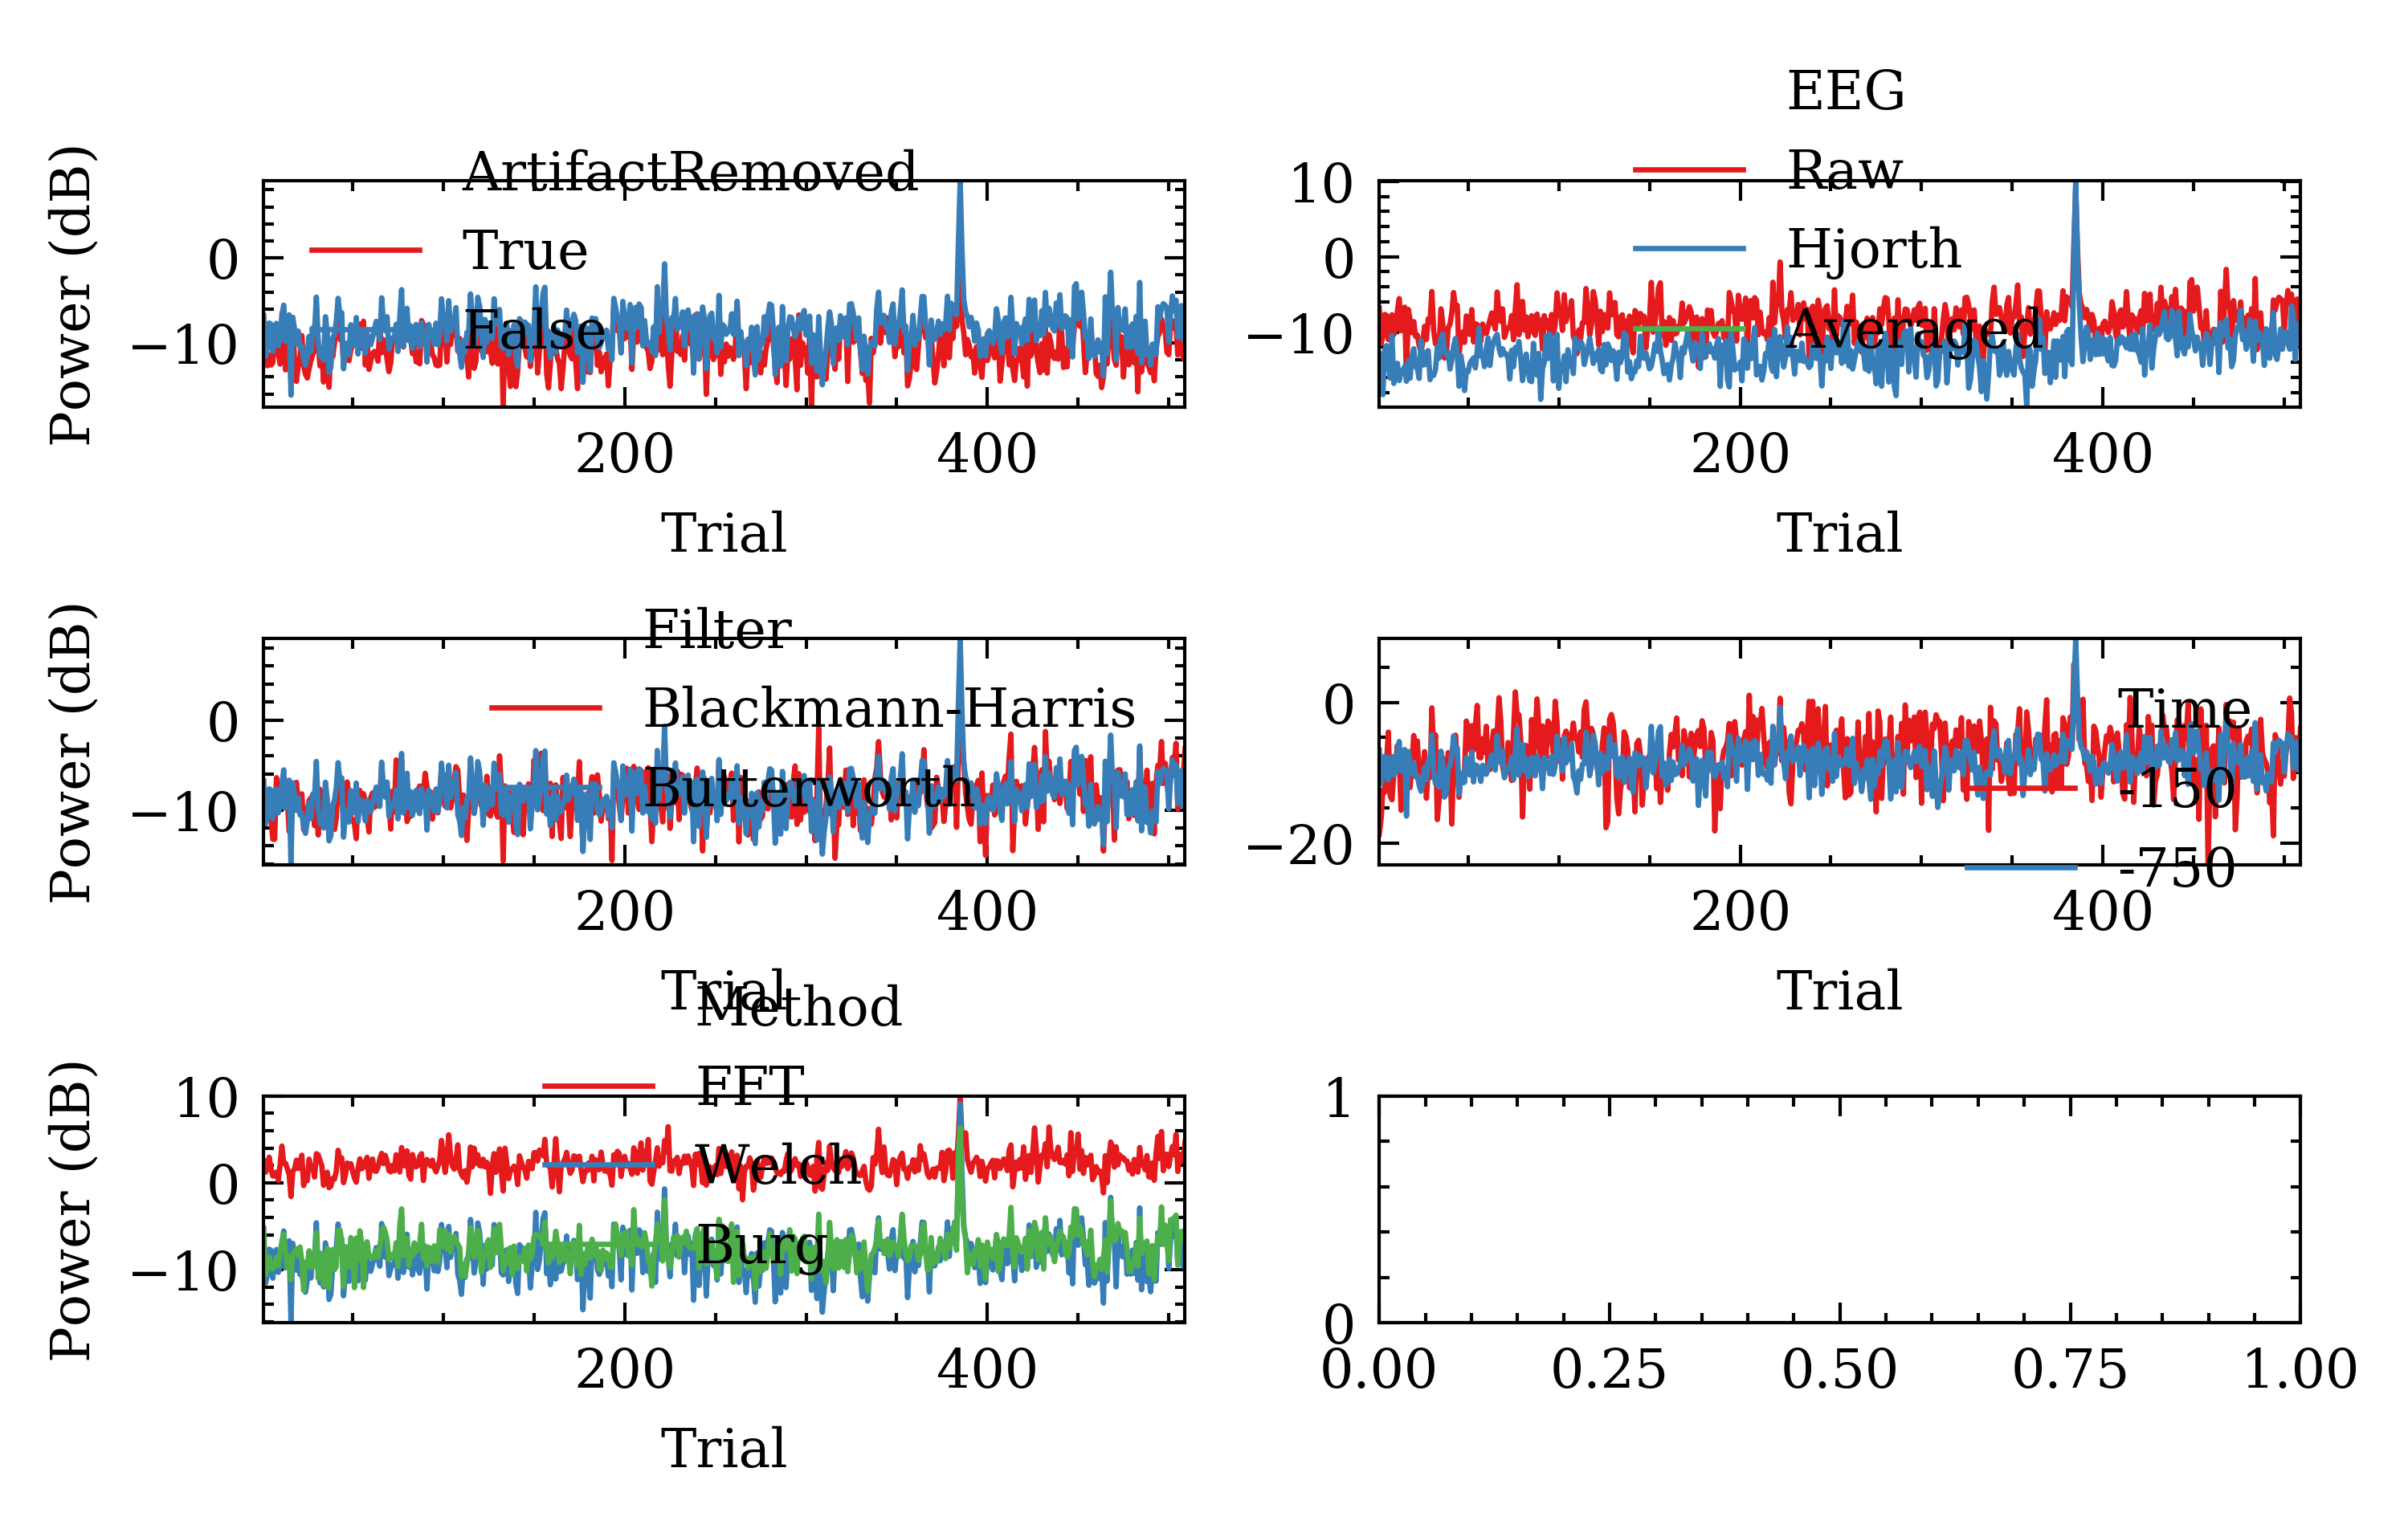

In [7]:
df_power2 = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
df_power2 = df_power2[df_power2['Band'] == 'Beta']
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(3, 2, figsize=(5,3))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        df_power3 = df_power3[['trial', 'Power', variable]]
        sns.lineplot(x="trial", y="Power", hue=variable, data=df_power3, ax=axs[i, j], hue_order=hue_order_power[variable], palette=sns.color_palette("Set1", df_power3[variable].nunique()))
        # axs[i, j].set_ylim([-25,35])
        # plt.setp(axs[i, j].lines, color='k')
        # axs[i, j].get_legend().remove()
        axs[i,j].set_xlabel('Trial')
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
#             axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1

    plt.tight_layout()

## Box plots - PSD

--------------
ArtifactRemoved
--------------
Performing EEG = Raw for constant ArtifactRemoved, shape = (48864, 10)
Performing Filter = Butterworth for constant ArtifactRemoved, shape = (24432, 10)
Performing Time = -750 for constant ArtifactRemoved, shape = (12216, 10)
Performing Method = Welch for constant ArtifactRemoved, shape = (4072, 10)
--------------
EEG
--------------
Performing ArtifactRemoved = False for constant EEG, shape = (73296, 10)
Performing Filter = Butterworth for constant EEG, shape = (36648, 10)
Performing Time = -750 for constant EEG, shape = (18324, 10)
Performing Method = Welch for constant EEG, shape = (6108, 10)
--------------
Filter
--------------
Performing ArtifactRemoved = False for constant Filter, shape = (73296, 10)
Performing EEG = Raw for constant Filter, shape = (24432, 10)
Performing Time = -750 for constant Filter, shape = (12216, 10)
Performing Method = Welch for constant Filter, shape = (4072, 10)
--------------
Time
--------------
Performing A

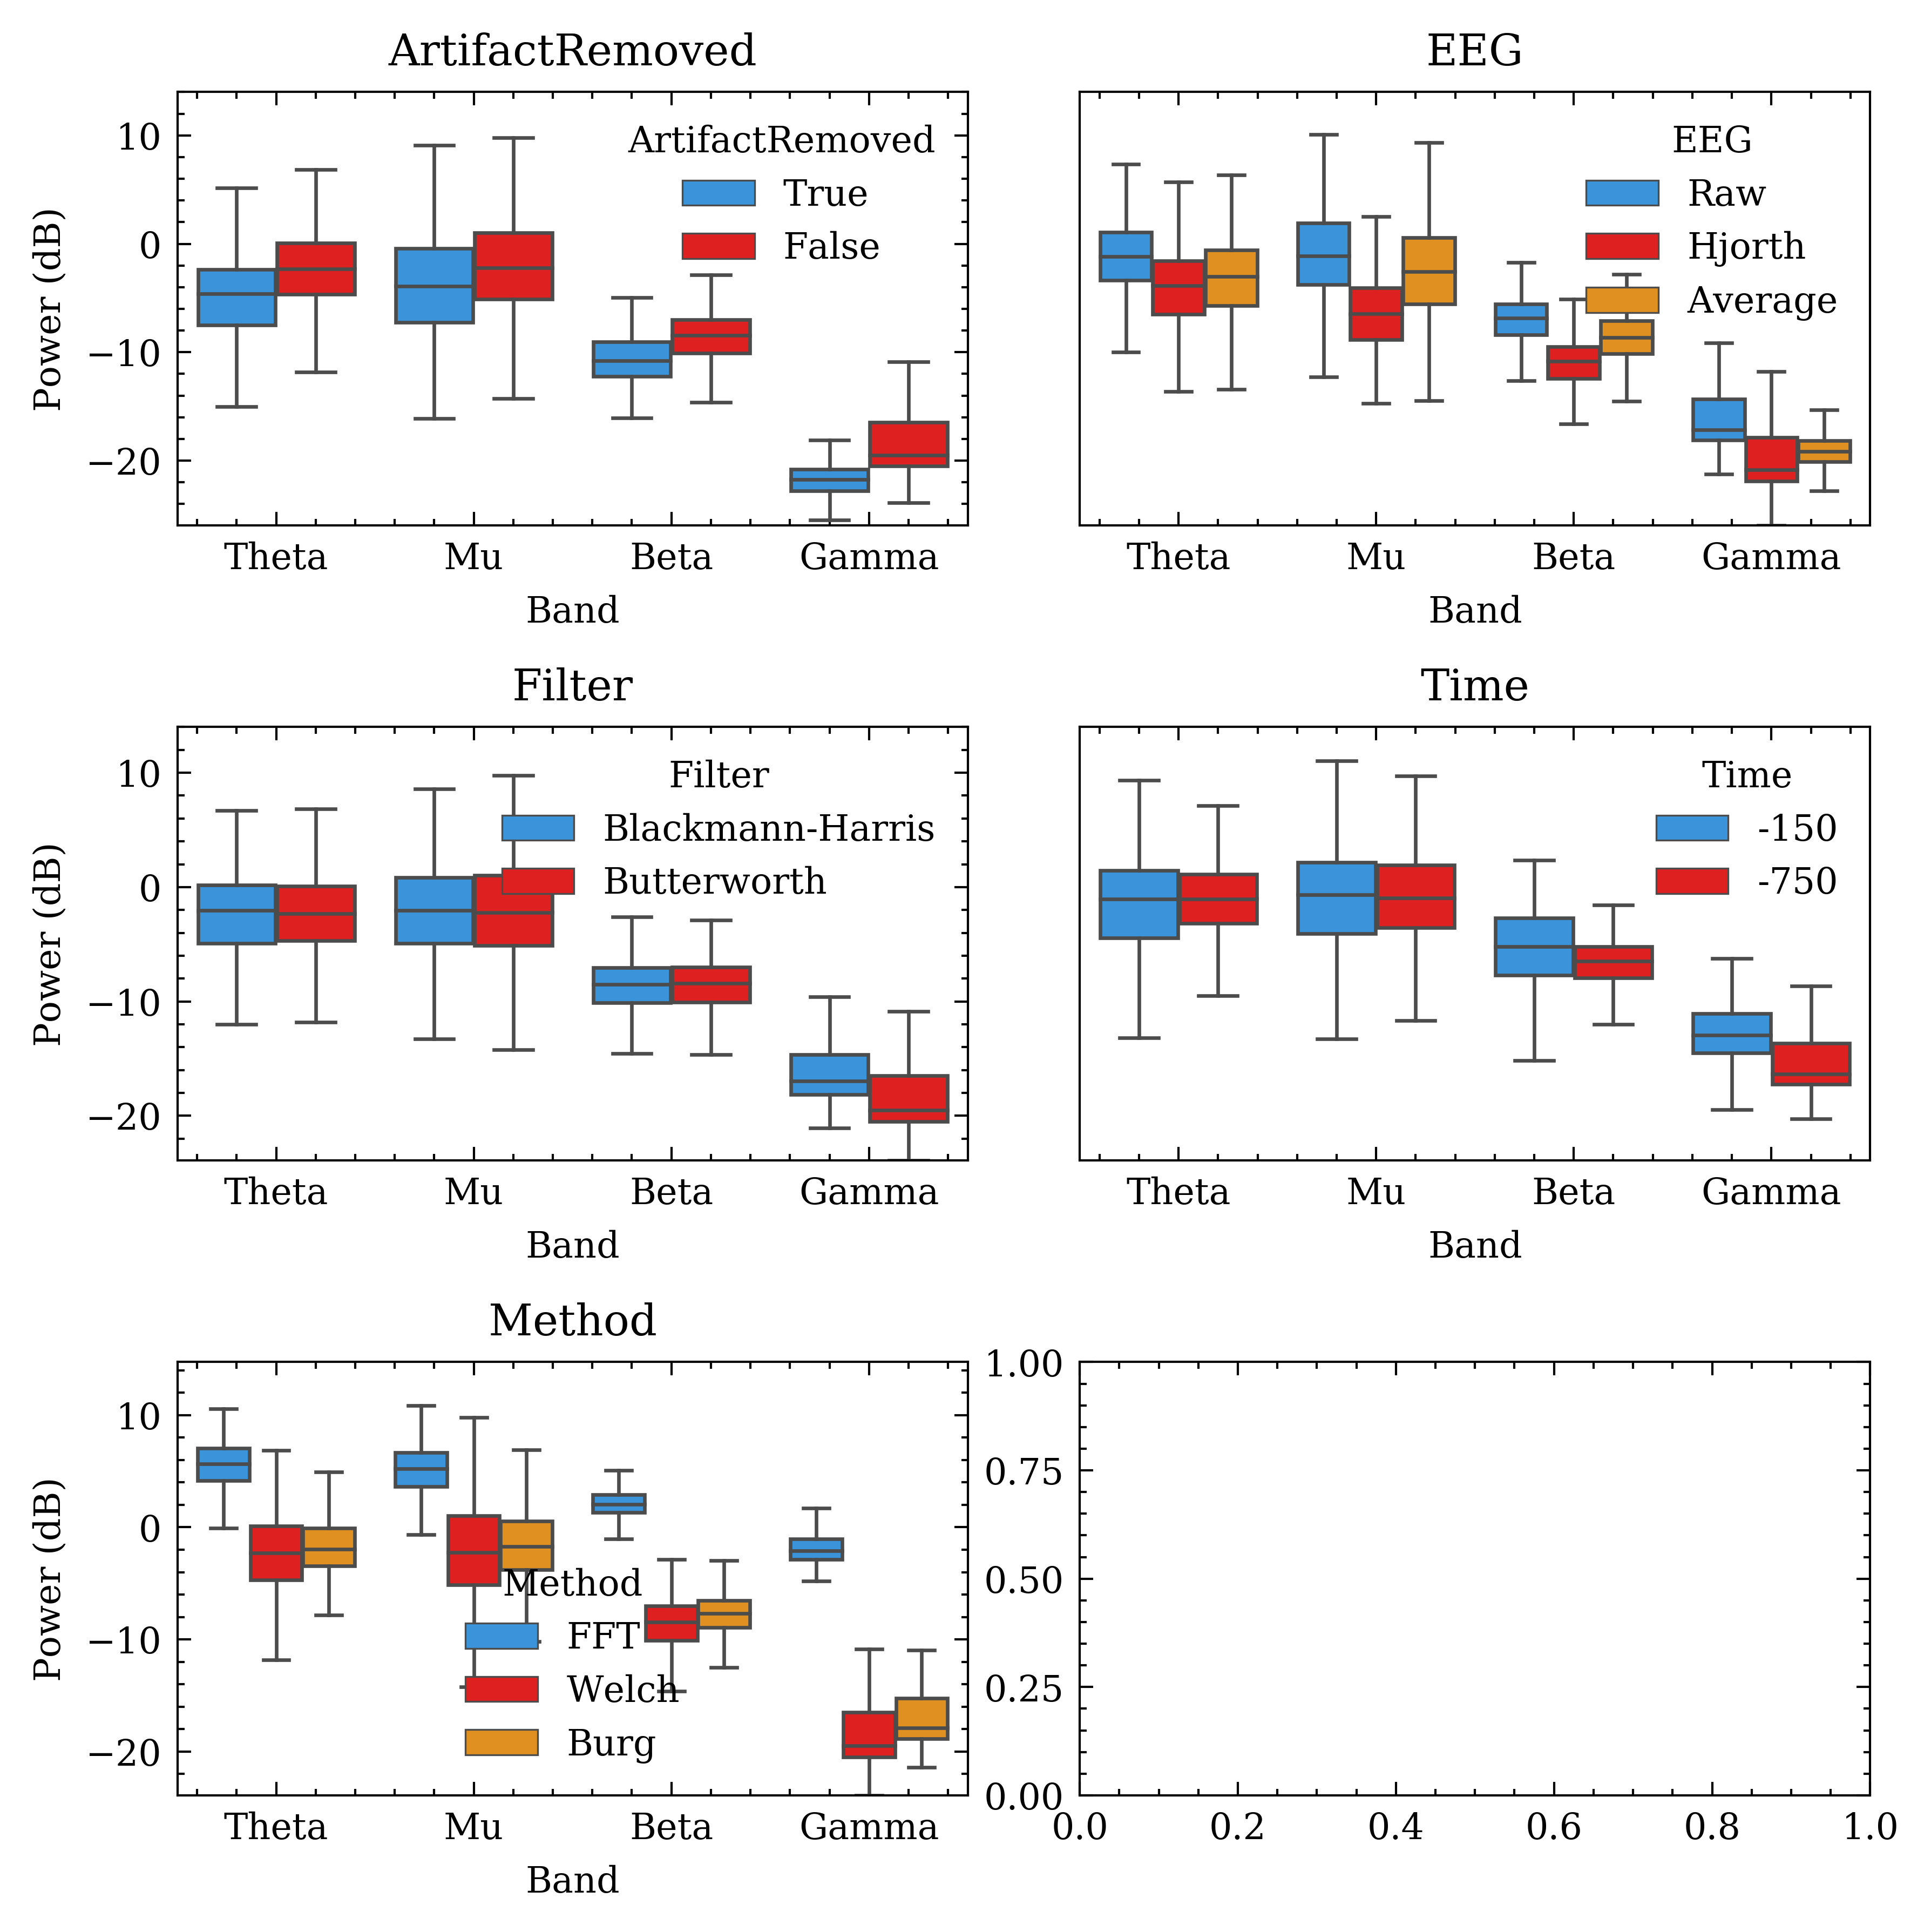

In [10]:
df_power2 = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(3,2,figsize=(6, 6))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):    
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        sns.boxplot(x="Band", y="Power", hue=variable, data=df_power3, ax=axs[i, j], fliersize=0, hue_order=hue_order_power[variable])
        # axs[i, j].set_ylim([-25,30])
        # plt.setp(axs[i, j].lines, color='k')
        axs[i, j].set_title(variable)
        # axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1

    plt.tight_layout()

## Interaction plot - PSD

Plotting in (0, 0): ('ArtifactRemoved', 'EEG'), shape: (3054, 10), unique1: [False  True], unique2: ['Raw' 'Hjorth' 'Average']
Plotting in (0, 1): ('ArtifactRemoved', 'Filter'), shape: (2036, 10), unique1: [False  True], unique2: ['Butterworth' 'Blackmann-Harris']
Plotting in (1, 0): ('ArtifactRemoved', 'Time'), shape: (2036, 10), unique1: [False  True], unique2: [-150 -750]
Plotting in (1, 1): ('ArtifactRemoved', 'Method'), shape: (3054, 10), unique1: [False  True], unique2: ['Welch' 'FFT' 'Burg']
Plotting in (2, 0): ('EEG', 'Filter'), shape: (3054, 10), unique1: ['Raw' 'Hjorth' 'Average'], unique2: ['Butterworth' 'Blackmann-Harris']
Plotting in (2, 1): ('EEG', 'Time'), shape: (3054, 10), unique1: ['Raw' 'Hjorth' 'Average'], unique2: [-150 -750]
Plotting in (3, 0): ('EEG', 'Method'), shape: (4581, 10), unique1: ['Raw' 'Hjorth' 'Average'], unique2: ['Welch' 'FFT' 'Burg']
Plotting in (3, 1): ('Filter', 'Time'), shape: (2036, 10), unique1: ['Butterworth' 'Blackmann-Harris'], unique2: [-1

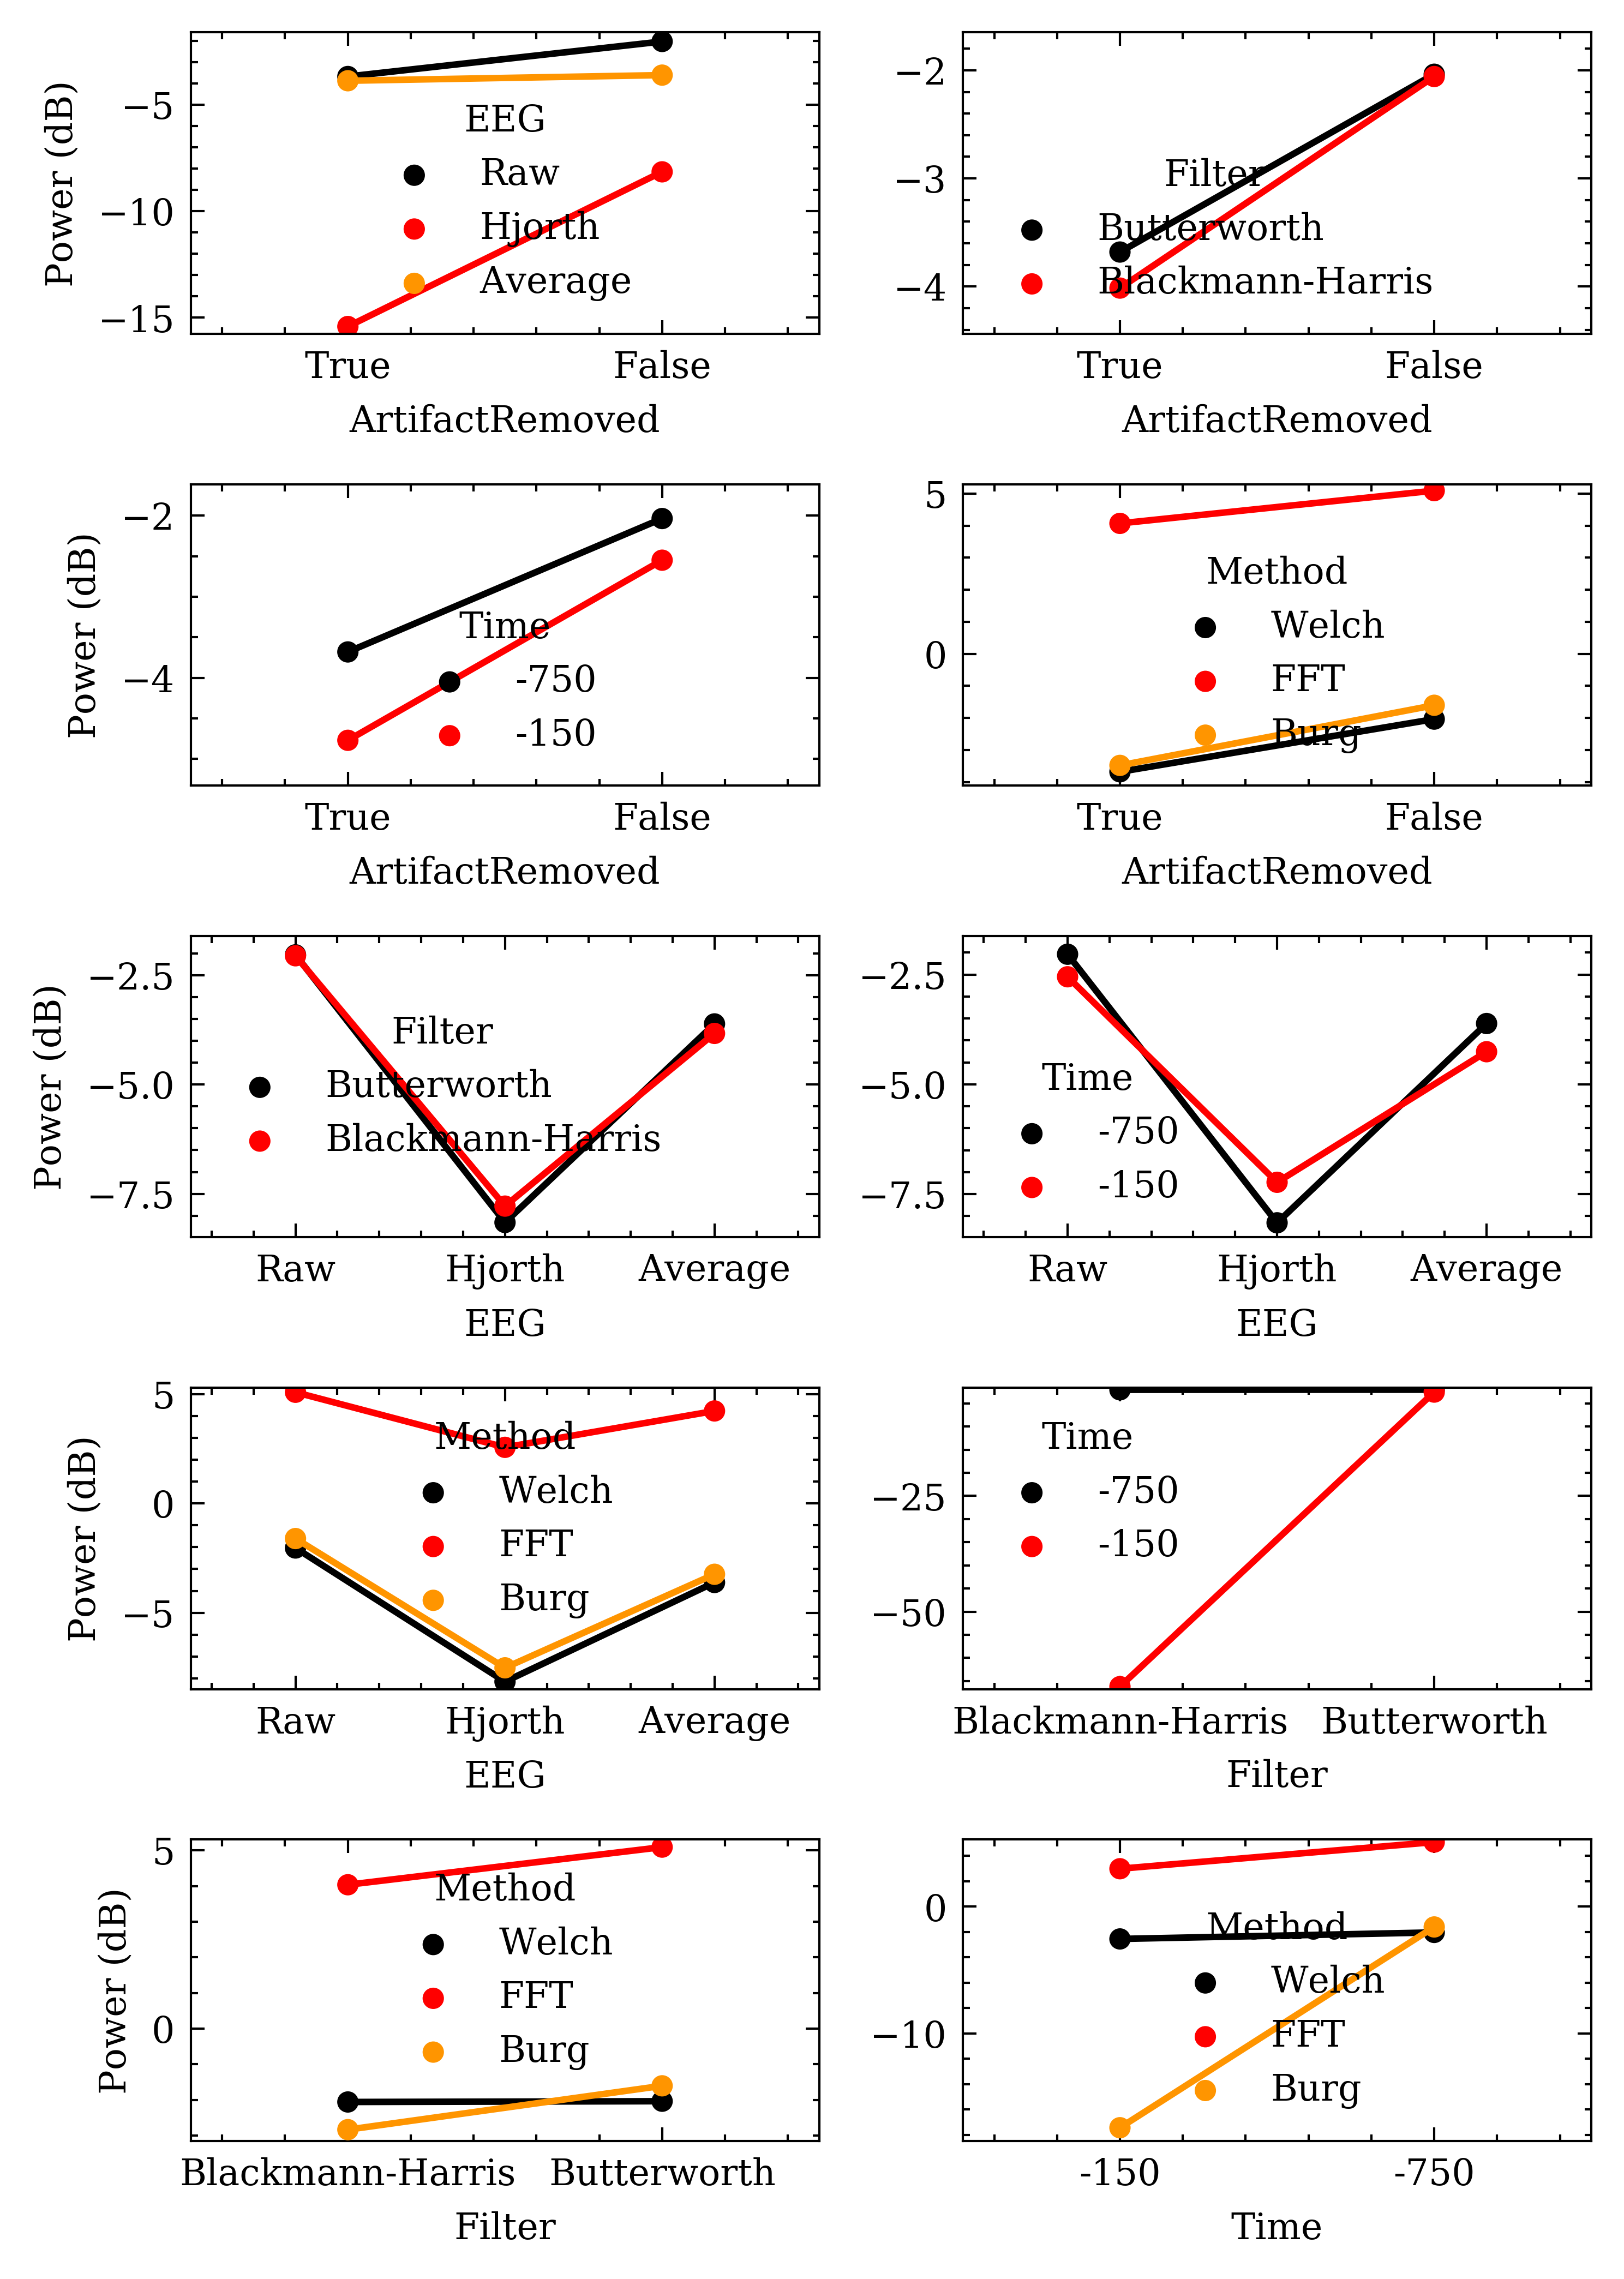

In [12]:
combs = list(combinations(list(def_values_power.keys()), 2))
df_power2 = df_power[df_power['Band'] == 'Mu']
df_power2 = df_power2[df_power2['sub'] == df_power2['sub'].unique()[10]]
i = 0
j = 0
with plt.style.context(['science-raquib']):
    f, axs = plt.subplots(5,2,figsize=(5,7))
    for comb in tqdm(combs):
        df_power3 = df_power2.copy()
        for key, value in def_values_power.items():
            if key not in comb:
                df_power3 = df_power3[df_power3[key] == value]
        print("Plotting in ({}, {}): {}, shape: {}, unique1: {}, unique2: {}".format(i, j, comb, df_power3.shape, df_power3[comb[0]].unique(), df_power3[comb[1]].unique()))
        df_power3 = df_power3[[comb[0], comb[1], 'Power']]
        sns.pointplot(x=comb[0], y="Power", hue=comb[1], data=df_power3, errwidth=0, ax=axs[i,j], order=hue_order_power[comb[0]])
        # axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')

        else:
            axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel(comb[0])
        # axs[i, j].set_ylim([-12, 32])
        j = j + 1
        if j > 1:
            i = i + 1
            j = 0
    plt.tight_layout()

## Histogram - phases

ArtifactRemoved, Band: Theta, Options: [False  True]
ArtifactRemoved, Band: Mu, Options: [False  True]
ArtifactRemoved, Band: Beta, Options: [False  True]
ArtifactRemoved, Band: Gamma, Options: [False  True]
EEG, Band: Theta, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Mu, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Beta, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Gamma, Options: ['Raw' 'Hjorth' 'Average']
Filter, Band: Theta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Mu, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Beta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Gamma, Options: ['Butterworth' 'Blackmann-Harris']



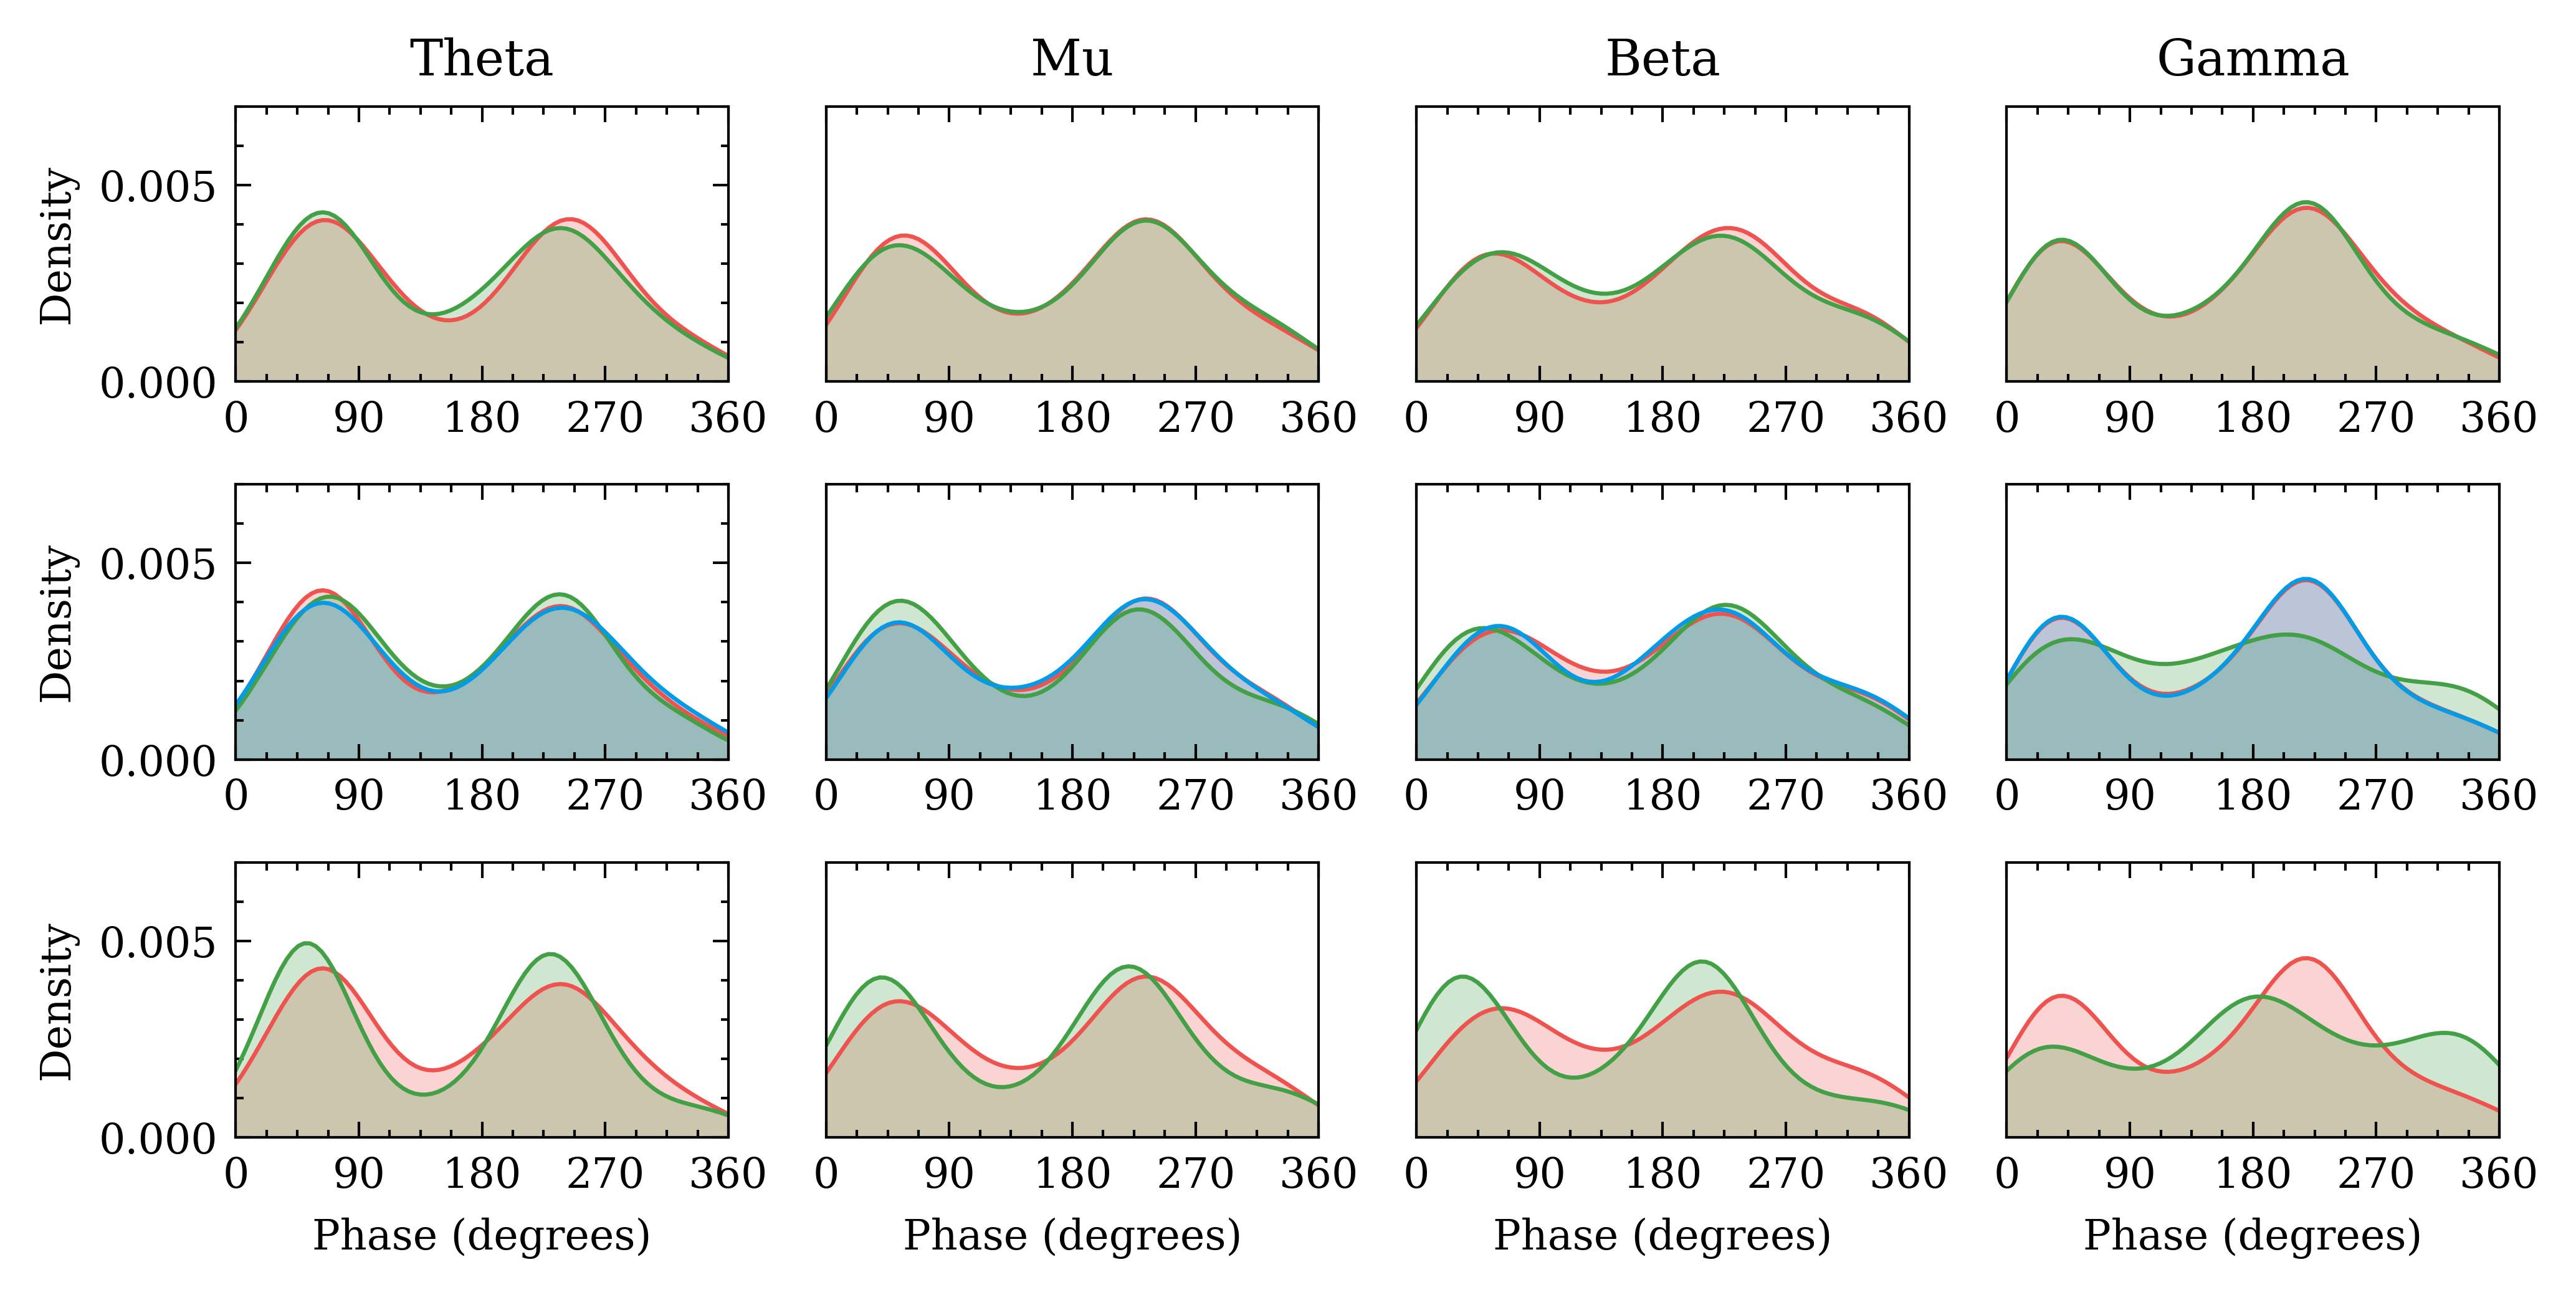

In [16]:
df_phase2 = df_phase[df_phase['sub'] == df_phase['sub'].unique()[10]]

with plt.style.context(['science-raquib']):
    colors = ['#EF5350', '#43A047', '#039BE5']
    f, axs = plt.subplots(3, 4, figsize=(7,3.5))
    i = 0
    j = 0
    color_ind = 0
    for variable in tqdm(list(def_values_phase.keys())):
        df_phase3 = df_phase2.copy()
        for key, value in def_values_phase.items():
                if key != variable:
                    df_phase3 = df_phase3[df_phase3[key] == value]
        for band in ['Theta', 'Mu', 'Beta', 'Gamma']:
            print('{}, Band: {}, Options: {}'.format(variable, band, df_phase3[variable].unique()))
            for option in df_phase3[variable].unique():
                df_phase4 = df_phase3[df_phase3['Band'] == band]
                df_phase4 = df_phase4[df_phase4[variable] == option]
                sns.distplot(df_phase4['Phase'], hist=False, color=colors[color_ind], kde_kws={"shade": True}, ax=axs[i, j])
                color_ind = color_ind + 1
                if i == 2:
                    axs[i, j].set_xlabel('Phase (degrees)')
                else:
                    axs[i, j].set_xlabel('')
                axs[i, j].set_xlim([0, 360])
                axs[i, j].set_ylim([0, 0.007])
                axs[i, j].set_xticks([0, 90, 180, 270, 360])
            if i == 0:
                axs[i, j].set_title(band)
            if j == 0:
                axs[i, j].set_ylabel('Density')
            else:
                axs[i, j].get_yaxis().set_visible(False)
            j = j + 1
            if j > 3:
                j = 0
            color_ind = 0
        i = i + 1
        
    plt.tight_layout()